# IMDb Webscraper for Top 250 Charts

### In this project, we will be web scraping the top 250 movie charts for 3 different sorting options: rating, popularity, and ranking

#### Here is a preview of the information we can scrape. Unfortunately, the movie genre(s) cannot be scraped from this
![example](example-movie-card.png)

## Scraping Data

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import json

#### Use Selenium to open and retrieve html sources. Return a BeautifulSoup object with that html source
Run the cell below again to retrieve the latest data. This may take a while as the page loading is quite slow

In [3]:
def get_html_source(url):
    # add headers to prevent being perceived as a bot when making requests
    options = Options()
    options.add_argument("--headless") # request url without opening browser
    options.add_argument("referer=https://www.google.com")
    options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36")
    
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    
    # clicking the button to list more information about the movies
    wait = WebDriverWait(driver, 10)
    button = wait.until(EC.element_to_be_clickable((By.ID, 'list-view-option-detailed')))
    button.click()
    
    # scrolling down with a delay to ensure the whole document is loaded
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(1)

    soup = BeautifulSoup(driver.page_source, 'html.parser')

    driver.quit()

    return soup

In [4]:
urls = {
    'imdb_rating': 'https://www.imdb.com/chart/top/?ref_=nv_mv_250&sort=user_rating%2Cdesc',
    'popularity': 'https://www.imdb.com/chart/top/?ref_=nv_mv_250&sort=popularity%2Casc',
    'ranking': 'https://www.imdb.com/chart/top/?ref_=nv_mv_250&sort=rank%2Casc',
}

rating_soup = get_html_source(urls['imdb_rating'])
popularity_soup = get_html_source(urls['popularity'])
ranking_soup = get_html_source(urls['ranking'])

#### Scrape and save the data locally to prevent repetitive requests
We will write all the data into a json file for easy viewing

In [5]:
def scrape(soup):
    ul = soup.find('ul', class_='ipc-metadata-list')
    movie_list = []

    for movie in ul:
        position = int(movie.find('h3').text.split('. ')[0])
        title = movie.find('h3').text.split('. ')[1]
        info = {
            'year': int(movie.find('div', class_='sc-b189961a-7').find_all('span')[0].text),
            'length': movie.find('div', class_='sc-b189961a-7').find_all('span')[1].text,
            'age_rating': movie.find('div', class_='sc-b189961a-7').find_all('span')[-1].text
        }
        # Some movies may have a blank field for age rating
        if info['length'] == info['age_rating']:
            info['age_rating'] = 'Not Rated'
    
        star_rating = float(movie.find('svg', class_='ipc-icon--star-inline').next_sibling)
        number_of_ratings = movie.find('span', class_='ipc-rating-star--voteCount').text
        director = movie.find('a', class_='ipc-link ipc-link--base dli-director-item').text
        starring = [starring.text for starring in movie.find('div', class_='sc-ab6fa25a-1 bBwFsP').find_all('a', class_='ipc-link ipc-link--base dli-cast-item')]
        
        movie_list.append(
            {
                'position': position,
                'title': title,
                'year': info['year'],
                'length': info['length'],
                'age_rating': info['age_rating'],
                'star_rating': star_rating,
                'number_of_ratings': number_of_ratings,
                'director': director,
                'starring': starring
            }
        )
    
    data_json = json.dumps(movie_list, indent=4)
    return data_json

Make sure to check the json files to ensure all 250 movie data was recorded. If not, rerun the cell above, then rerun this cell below

In [6]:
with open('rating.json', 'w') as rating, open('popularity.json', 'w') as popularity, open('ranking.json', 'w') as ranking:
    rating.write(scrape(rating_soup))
    popularity.write(scrape(popularity_soup))
    ranking.write(scrape(ranking_soup))

# Analysis

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Top 250 Movies by Rating

In [8]:
with open('rating.json', 'r') as rating:
    rating_data = json.load(rating)

df_rating = pd.DataFrame(rating_data)
df_rating.head()

,position,title,year,length,age_rating,star_rating,number_of_ratings,director,starring
0,1,The Shawshank Redemption,1994,2h 22m,R,9.3,(2.9M),Frank Darabont,"[Tim Robbins, Morgan Freeman, Bob Gunton]"
1,2,The Godfather,1972,2h 55m,R,9.2,(2M),Francis Ford Coppola,"[Marlon Brando, Al Pacino, James Caan]"
2,3,The Dark Knight,2008,2h 32m,PG-13,9.0,(2.9M),Christopher Nolan,"[Christian Bale, Heath Ledger, Aaron Eckhart]"
3,4,12th Fail,2023,2h 27m,Not Rated,9.0,(109K),Vidhu Vinod Chopra,"[Vikrant Massey, Medha Shankr, Anant Joshi]"
4,5,Schindler's List,1993,3h 15m,R,9.0,(1.4M),Steven Spielberg,"[Liam Neeson, Ralph Fiennes, Ben Kingsley]"


#### Top 250 Movies by Popularity

In [9]:
with open('popularity.json', 'r') as popularity:
    popularity_data = json.load(popularity)

df_popularity = pd.DataFrame(popularity_data)
df_popularity.head()

,position,title,year,length,age_rating,star_rating,number_of_ratings,director,starring
0,1,Dune: Part Two,2024,2h 46m,PG-13,8.7,(338K),Denis Villeneuve,"[Timothée Chalamet, Zendaya, Rebecca Ferguson]"
1,2,Oppenheimer,2023,3h,R,8.3,(716K),Christopher Nolan,"[Cillian Murphy, Emily Blunt, Matt Damon]"
2,3,Godzilla Minus One,2023,2h 4m,PG-13,8.3,(48K),Takashi Yamazaki,"[Minami Hamabe, Sakura Andô, Ryunosuke Kamiki]"
3,4,Interstellar,2014,2h 49m,PG-13,8.7,(2.1M),Christopher Nolan,"[Matthew McConaughey, Anne Hathaway, Jessica C..."
4,5,The Shawshank Redemption,1994,2h 22m,R,9.3,(2.9M),Frank Darabont,"[Tim Robbins, Morgan Freeman, Bob Gunton]"


#### Comparing top rated vs most popular movies by the decades

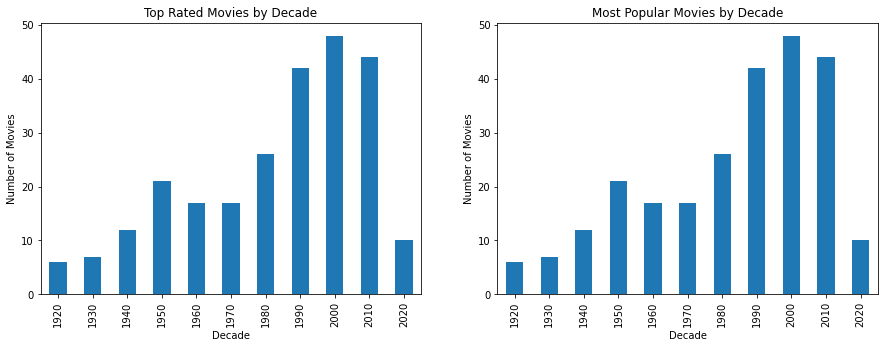

The top rated movies were made in the 2000s
The most popular movies as of now were made in the 2000s


In [10]:
top_rated_years = df_rating['year']
most_popular_years = df_popularity['year']

top_rated_decade = top_rated_years // 10 * 10
most_popular_decade = most_popular_years // 10 * 10

tr_decade_freq = top_rated_decade.value_counts().sort_index()
mp_decade_freq = most_popular_decade.value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
tr_decade_freq.plot(kind='bar', title='Top Rated Movies by Decade', xlabel='Decade', ylabel='Number of Movies', ax=ax1)
mp_decade_freq.plot(kind='bar', title='Most Popular Movies by Decade', xlabel='Decade', ylabel='Number of Movies', ax=ax2)
plt.show()

print(f'The top rated movies were made in the {top_rated_decade.value_counts().keys()[0]}s')
print(f'The most popular movies as of now were made in the {most_popular_decade.value_counts().keys()[0]}s')

#### Comparing age ratings in top rated vs most popular movies

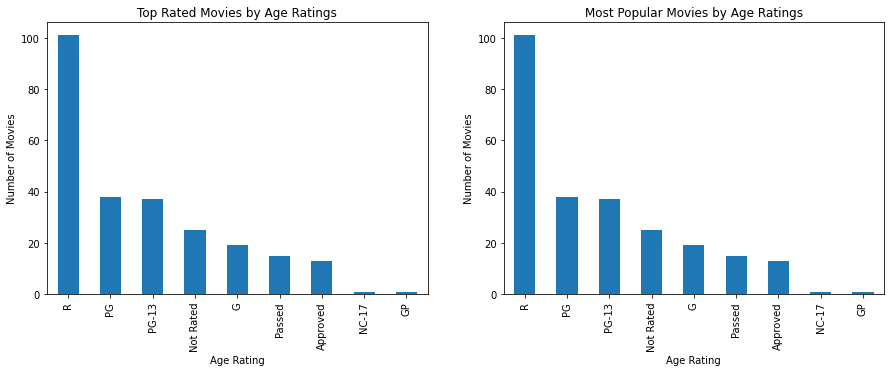

The top rated movies are mostly R rated
The most popular movies are mostly R rated


In [11]:
top_age = df_rating['age_rating'].value_counts()
popular_age = df_popularity['age_rating'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
top_age.plot(kind='bar', title='Top Rated Movies by Age Ratings', xlabel='Age Rating', ylabel='Number of Movies', ax=ax1)
popular_age.plot(kind='bar', title='Most Popular Movies by Age Ratings', xlabel='Age Rating', ylabel='Number of Movies', ax=ax2)
plt.show()

print(f'The top rated movies are mostly {top_age.keys()[0]} rated')
print(f'The most popular movies are mostly {popular_age.keys()[0]} rated')

#### Comparing directors in top rated vs most popular movies

In [12]:
top_director = df_rating['director']
popular_director = df_popularity['director']

print('The top 5 directors for the top rated movies are: ')
for i in range(5):
    print(f'{i+1}. {top_director.value_counts().keys()[i]}')

print('\nThe top 5 directors for the most popular movies are: ')
for i in range(5):
    print(f'{i+1}. {popular_director.value_counts().keys()[i]}')

The top 5 directors for the top rated movies are: 
1. Christopher Nolan
2. Martin Scorsese
3. Stanley Kubrick
4. Steven Spielberg
5. Akira Kurosawa

The top 5 directors for the most popular movies are: 
1. Christopher Nolan
2. Stanley Kubrick
3. Steven Spielberg
4. Martin Scorsese
5. Akira Kurosawa


#### Comparing starring casts in top rated vs most popular movies

In [13]:
# convert the starring items to a list
top_stars = df_rating['starring']
popular_stars = df_popularity['starring']

top_stars = [star for sublist in top_stars for star in sublist]
popular_stars = [star for sublist in popular_stars for star in sublist]

df_top_stars = pd.DataFrame(top_stars)
df_popular_stars = pd.DataFrame(popular_stars)

print('The top 5 starring casts for the top rated movies are: ')
for i in range(5):
    print(f'{i+1}. {df_top_stars.value_counts().keys()[i][0]}')

print('\nThe top 5 starring casts for the most popular movies are: ')
for i in range(5):
    print(f'{i+1}. {df_popular_stars.value_counts().keys()[i][0]}')

The top 5 starring casts for the top rated movies are: 
1. Robert De Niro
2. Leonardo DiCaprio
3. Tom Hanks
4. Harrison Ford
5. Clint Eastwood

The top 5 starring casts for the most popular movies are: 
1. Robert De Niro
2. Leonardo DiCaprio
3. Tom Hanks
4. Harrison Ford
5. Clint Eastwood


Comparison of release dates, age ratings, directors, and starring casts all looked identical for both of the 250 top rated and most popular movies charts. We can infer that most, if not all, of the top rated movies are also the most popular movies out there as of today.